# Tokenization
Tokenizer is a completely separate, independent module from the LLM. It has its own training dataset of text (which could be different from that of the LLM), on which you train the vocabulary. It then translates back and forth between raw text and sequences of tokens. The LLM later only ever sees the tokens and never directly deals with any text.
- WordPiece Tokenizer: Used by models like BERT.
- BPE Tokenizer: Used by models like GPT-2 and GPT-3.
- SentencePiece Tokenizer: Often used in machine translation models, such as T5 and some versions of BERT.
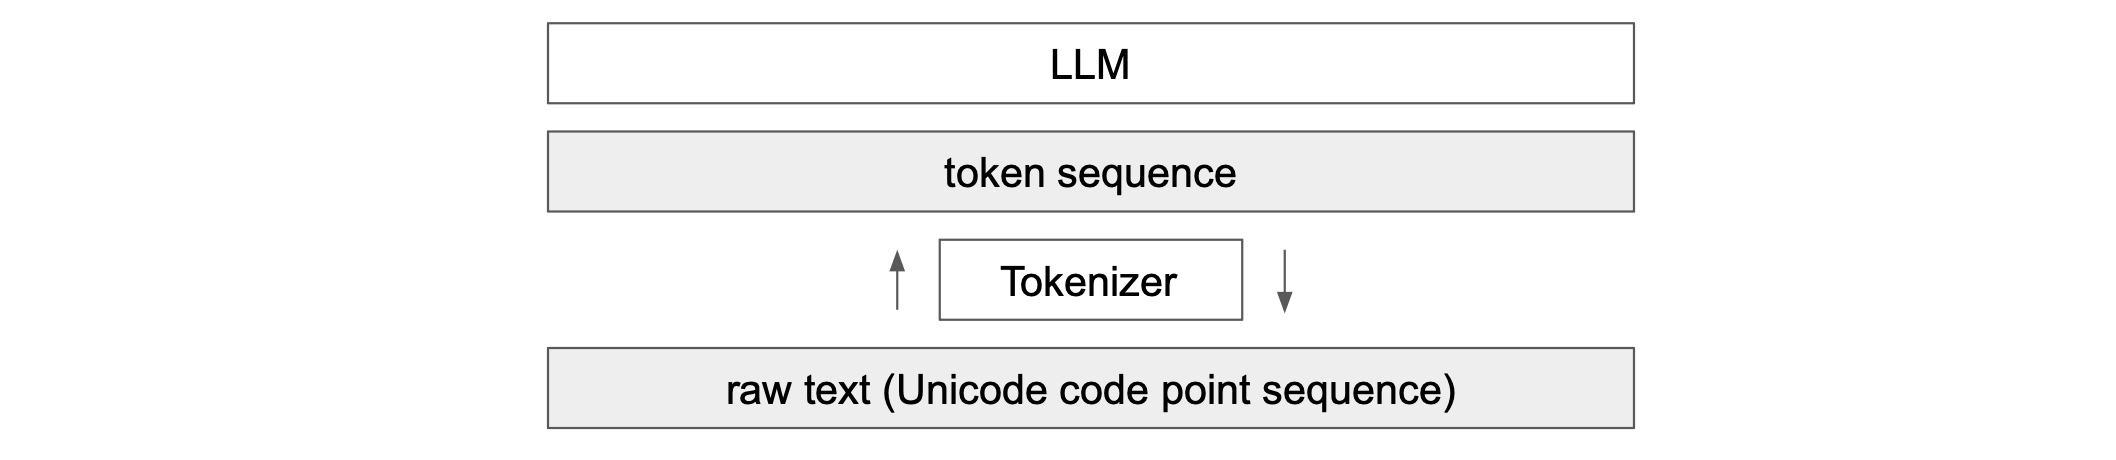

In [3]:
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255 for convenience
print('---')
print(text)
print("length:", len(text))
print('---')
print(tokens)
print("length:", len(tokens))

---
Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.
length: 533
---
[239, 188, 181, 239, 189, 142, 239, 189, 137, 239, 189, 131, 239, 189, 143, 239, 189, 132, 239, 189, 133, 33, 32, 240, 159, 133, 164, 240, 159, 133, 157, 240, 159, 133, 152, 240, 159, 133, 146, 240, 159, 133, 158, 240, 159, 133, 147, 240, 159, 133, 148, 226, 128, 189, 32, 240, 159, 135, 186, 226, 128, 140, 240, 159, 135, 179, 226, 128, 140, 240, 159, 135, 174, 226, 128, 140, 240, 159, 135, 168, 226, 128, 140, 240, 159, 135, 180, 226, 128, 140

In [5]:
# function to count the number of unique pairs in the text
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

In [6]:
stats = get_stats(tokens)
top_pair = max(stats, key=stats.get)
top_pair

(101, 32)

In [7]:
# replace all pairs with idx in ids list
def merge(ids, pair, idx):
    new_ids = []
    i=0
    while i < len(ids):
        if i < len(ids) - 1 and ids[i]==pair[0] and ids[i+1]==pair[1]:
            new_ids.append(idx)
            i+=2
        else:
            new_ids.append(ids[i])
            i+=1
            
    return new_ids

In [10]:
print(merge([7,3,4,5,6,3,3,4,5], (3,4), 99))
print(f'Length before merge: {len(tokens)}\nLength after merging the top pair {top_pair}: {len(merge(tokens, top_pair, 256))}')

[7, 99, 5, 6, 3, 99, 5]
Length before merge: 616
Length after merging the top pair (101, 32): 596


In [11]:
vocab_size = 276 # desired final vocabulary size
num_merges = vocab_size - 256
ids = list(tokens)

In [12]:
merges = {}
for i in range(num_merges):
    stats = get_stats(tokens)
    top_pair = max(stats, key=stats.get)
    idx = 256 + i
    print(f"merging {top_pair} into token {idx}")
    tokens = merge(tokens, top_pair, idx)
    merges[top_pair]=idx

merging (101, 32) into token 256
merging (240, 159) into token 257
merging (226, 128) into token 258
merging (105, 110) into token 259
merging (115, 32) into token 260
merging (97, 110) into token 261
merging (116, 104) into token 262
merging (257, 133) into token 263
merging (257, 135) into token 264
merging (97, 114) into token 265
merging (239, 189) into token 266
merging (258, 140) into token 267
merging (267, 264) into token 268
merging (101, 114) into token 269
merging (111, 114) into token 270
merging (116, 32) into token 271
merging (259, 103) into token 272
merging (115, 116) into token 273
merging (261, 100) into token 274
merging (32, 262) into token 275


In [13]:
print("tokens length:", len(tokens))
print("ids length:", len(ids))
print(f"compression ratio: {len(tokens) / len(ids):.2f}X")

tokens length: 451
ids length: 616
compression ratio: 0.73X


In [14]:
merges

{(101, 32): 256,
 (240, 159): 257,
 (226, 128): 258,
 (105, 110): 259,
 (115, 32): 260,
 (97, 110): 261,
 (116, 104): 262,
 (257, 133): 263,
 (257, 135): 264,
 (97, 114): 265,
 (239, 189): 266,
 (258, 140): 267,
 (267, 264): 268,
 (101, 114): 269,
 (111, 114): 270,
 (116, 32): 271,
 (259, 103): 272,
 (115, 116): 273,
 (261, 100): 274,
 (32, 262): 275}

### Decoding

In [20]:
# create vocabulary
vocab = {idx: bytes([idx]) for idx in range(256)}
for (p0, p1), idx in merges.items():
    vocab[idx] = vocab[p0]+vocab[p1]

len(vocab)

276

In [54]:
vocab

{0: b'\x00',
 1: b'\x01',
 2: b'\x02',
 3: b'\x03',
 4: b'\x04',
 5: b'\x05',
 6: b'\x06',
 7: b'\x07',
 8: b'\x08',
 9: b'\t',
 10: b'\n',
 11: b'\x0b',
 12: b'\x0c',
 13: b'\r',
 14: b'\x0e',
 15: b'\x0f',
 16: b'\x10',
 17: b'\x11',
 18: b'\x12',
 19: b'\x13',
 20: b'\x14',
 21: b'\x15',
 22: b'\x16',
 23: b'\x17',
 24: b'\x18',
 25: b'\x19',
 26: b'\x1a',
 27: b'\x1b',
 28: b'\x1c',
 29: b'\x1d',
 30: b'\x1e',
 31: b'\x1f',
 32: b' ',
 33: b'!',
 34: b'"',
 35: b'#',
 36: b'$',
 37: b'%',
 38: b'&',
 39: b"'",
 40: b'(',
 41: b')',
 42: b'*',
 43: b'+',
 44: b',',
 45: b'-',
 46: b'.',
 47: b'/',
 48: b'0',
 49: b'1',
 50: b'2',
 51: b'3',
 52: b'4',
 53: b'5',
 54: b'6',
 55: b'7',
 56: b'8',
 57: b'9',
 58: b':',
 59: b';',
 60: b'<',
 61: b'=',
 62: b'>',
 63: b'?',
 64: b'@',
 65: b'A',
 66: b'B',
 67: b'C',
 68: b'D',
 69: b'E',
 70: b'F',
 71: b'G',
 72: b'H',
 73: b'I',
 74: b'J',
 75: b'K',
 76: b'L',
 77: b'M',
 78: b'N',
 79: b'O',
 80: b'P',
 81: b'Q',
 82: b'R',
 83: b'

In [23]:
def decode(ids):
    tokens = b"".join(vocab[idx] for idx in ids)
    text = tokens.decode("utf-8", errors="replace")
    return text

In [27]:
decode([100, 102]), decode([182])

('df', '�')

### Encoding

In [28]:
def encode(text):
    tokens = list(text.encode("utf-8"))
    while len(tokens) >= 2:
        stats = get_stats(tokens)
        pair = min(stats, key=lambda p: merges.get(p, float('inf')))
        if pair not in merges:
            break
        idx=merges[pair]
        tokens = merge(tokens, pair, idx)
    return tokens

In [29]:
print(decode(encode("hi there!")))

hi there!


In [30]:
text == decode(encode(text))

True

### Forced Splits using regex for GPT series

In [31]:
import regex as re
gpt2pat = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")

print(re.findall(gpt2pat, "Hello've world123 how's are you!!!?"))

['Hello', "'ve", ' world', '123', ' how', "'s", ' are', ' you', '!!!?']


In [32]:
example = """
for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
"""
print(re.findall(gpt2pat, example))

['\n', 'for', ' i', ' in', ' range', '(', '1', ',', ' 101', '):', '\n   ', ' if', ' i', ' %', ' 3', ' ==', ' 0', ' and', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'FizzBuzz', '")', '\n   ', ' elif', ' i', ' %', ' 3', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Fizz', '")', '\n   ', ' elif', ' i', ' %', ' 5', ' ==', ' 0', ':', '\n       ', ' print', '("', 'Buzz', '")', '\n   ', ' else', ':', '\n       ', ' print', '(', 'i', ')', '\n']


In [49]:
import tiktoken

# GPT-2 (does not merge spaces)
enc = tiktoken.get_encoding("gpt2")
print(enc.encode("    hello world!!!"))

# GPT-4 (merges spaces)
enc = tiktoken.get_encoding("cl100k_base")
print(enc.encode("    hello world!!!"))

[220, 220, 220, 23748, 995, 10185]
[262, 24748, 1917, 12340]


In [44]:
import wget
url = 'https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe'
url2 = 'https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json'
myfile = wget.download(url)
myfile2 = wget.download(url2)

100% [..........................................................................] 1042301 / 1042301

In [45]:
import os, json

with open('vocab.bpe', 'r', encoding='utf-8') as f:
    bpe_data = f.read()
    
with open('encoder.json', 'r') as f:
    encoder = json.load(f)

In [53]:
type(encoder), type(bpe_data)

(dict, str)

## Implementing Base Class
UTF-8 encoding ensures that characters from various languages are correctly represented as bytes, allowing the tokenizer to process them without errors.

In [111]:
class Tokenizer:
    """Base class for tokenizer"""
    def __init__(self):
        self.merges = {}
        self.vocab = {}
        self.token_set_len = 256
        self.pattern = None
        
    def get_stats(self, tokens):
        """Get the count for each pair in tokens"""
        counts = {}
        for pair in zip(tokens, tokens[1:]):
            counts[pair] = counts.get(pair, 0) + 1
        return counts
    
    def merge(self, tokens, pair, idx):
        """Replace the pair in tokens with idx"""
        new_tokens = []
        i=0
        while i < len(tokens):
            if i+1<len(tokens) and tokens[i]==pair[0] and tokens[i+1]==pair[1]:
                new_tokens.append(idx)
                i+=2
            else:
                new_tokens.append(tokens[i])
                i+=1
        return new_tokens
    
    def train(self, text, vocab_size=276):
        """Tokenizer can train a vocabulary of size vocab_size from text"""
        raise NotImplementedError
            
    def decode(self, ids):
        """Decode the tokens(list of integers) into text"""
        raise NotImplementedError

    def encode(self, text):
        """Encode text into list of integers"""
        raise NotImplementedError
    
    def _build_vocab(self):
        # vocab is simply and deterministically derived from merges
        vocab = {idx: bytes([idx]) for idx in range(self.token_set_len)}
        for (p0, p1), idx in self.merges.items():
            vocab[idx] = vocab[p0] + vocab[p1]
        return vocab

## Excercise 1: Basic Tokenizer
Write the BasicTokenizer class, with the following three core functions:

- def train(self, text, vocab_size, verbose=False)
- def encode(self, text)
- def decode(self, ids)
Train your tokenizer on whatever text you like and visualize the merged tokens. Do they look reasonable? One default test you may wish to use is the text file tests/taylorswift.txt.

In [115]:
# build a basic tokenizer
class BasicTokenizer(Tokenizer):
    def __init__(self):
        super().__init__()
        
    def train(self, text, vocab_size=276, verbose=False):
        """Train tokenizer for the given data"""
        assert vocab_size >= 256
        tokens = text.encode("utf-8") # raw bytes
        tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255
        
        num_merges = vocab_size - self.token_set_len
        
        self.vocab = self._build_vocab()

        for i in range(num_merges):
            stats = self.get_stats(tokens)
            if not stats:
                break
            top_pair = max(stats, key=stats.get)
            idx = self.token_set_len + i
            tokens = self.merge(tokens, top_pair, idx)
            self.merges[top_pair] = idx
            self.vocab[idx] = self.vocab[top_pair[0]] + self.vocab[top_pair[1]]
            
            if verbose:
                print(f"merge {i+1}/{num_merges}: {top_pair} -> {idx} ({self.vocab[idx]}) had {stats[top_pair]} occurrences")
    
        print("Vocabulary length:", len(self.vocab))
            
    def decode(self, ids):
        """Decode the tokens into text"""
        tokens = b"".join(self.vocab[idx] for idx in ids)
        text = tokens.decode("utf-8", errors="replace")
        return text

    def encode(self, text):
        tokens = list(text.encode("utf-8"))
        while len(tokens) >= 2:
            stats = self.get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float('inf')))
            if pair not in self.merges:
                break
            idx=self.merges[pair]
            tokens = self.merge(tokens, pair, idx)
        return tokens

In [116]:
with open('taylorswift.txt', 'r') as f:
    input_file = f.read()

In [126]:
tokenizer = BasicTokenizer()

# Train the tokenizer
tokenizer.train(input_file)

# Encode a text
encoded = tokenizer.encode("I stay out too late, got nothing in my brain.")
print("Encoded:", encoded)

# Decode the encoded text
decoded = tokenizer.decode(encoded)
print("Decoded:", decoded)

Vocabulary length: 276
Encoded: [73, 32, 115, 116, 97, 273, 111, 117, 266, 116, 111, 111, 32, 108, 97, 116, 101, 257, 103, 111, 266, 110, 111, 267, 263, 103, 32, 263, 32, 109, 273, 98, 114, 97, 263, 46]
Decoded: I stay out too late, got nothing in my brain.


In [127]:
tokenizer.decode(tokenizer.encode("hi there"))

'hi there'

In [128]:
tokenizer.decode(tokenizer.encode("안녕하세요 👋"))


'안녕하세요 👋'

## Excercise 2: Regex Tokenizer using GPT-4 split
Convert you BasicTokenizer into a RegexTokenizer, which takes a regex pattern and splits the text exactly as GPT-4 would. Process the parts separately as before, then concatenate the results. Retrain your tokenizer and compare the results before and after. You should see that you will now have no tokens that go across categories (numbers, letters, punctuation, more than one whitespace). Use the GPT-4 pattern:

`GPT4_SPLIT_PATTERN = r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+"""`


In [104]:
import regex

GPT4_SPLIT_PATTERN = r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+"""


In [136]:
class RegexTokenizer(Tokenizer):
    def __init__(self, pattern=None):
        super().__init__()
        self.pattern = GPT4_SPLIT_PATTERN if pattern is None else pattern
        self.compiled_pattern = re.compile(self.pattern)
        
    def train(self, text, vocab_size=276, verbose=False):
        assert vocab_size >= 256
        text_chunks = re.findall(self.compiled_pattern, text)
        tokens = [ch.encode('utf-8') for ch in text_chunks]
        
        num_merges = vocab_size - self.token_set_len
        self.vocab = self._build_vocab()
        
        for i in range(num_merges):
            stats = self.get_stats(tokens)
            if not stats:
                break
            top_pair = max(stats, key=stats.get)
            idx = self.token_set_len + i
            tokens = self.merge(tokens, top_pair, idx)
            self.merges[top_pair] = idx
            self.vocab[idx] = self.vocab[top_pair[0]] + self.vocab[top_pair[1]]
            
            if verbose:
                print(f"merge {i+1}/{num_merges}: {top_pair} -> {idx} ({self.vocab[idx]}) had {stats[top_pair]} occurrences")
    
        print("Vocabulary length:", len(self.vocab))

#     def decode(self, ids):
#         """Decode the tokens into text"""
#         decoded = b"".join(self.vocab[idx] for idx in ids)
#         text = decoded.decode("utf-8", errors="replace")
#         return text

#     def encode(self, text):
#         """Encode text to tokens using regex"""
       
#         tokens = 

#         while len(tokens) >= 2:
#             stats = self.get_stats(tokens)
#             pair = min(stats, key=lambda p: self.merges.get(p, float('inf')))
#             if pair not in self.merges:
#                 break
#             idx = self.merges[pair]
#             tokens = self.merge(tokens, pair, idx)

#         return tokens

        

In [137]:
reg_tokenizer = RegexTokenizer()
reg_tokenizer.train(input_file, verbose=True)


encoded = reg_tokenizer.encode("I stay out too late, got nothing in my brain.")
print("Encoded:", encoded)

decoded = reg_tokenizer.decode(encoded)
print("Decoded:", decoded)

KeyError: b','

In [130]:
reg_tokenizer.decode(reg_tokenizer.encode("hi there"))

'hi there'

In [131]:
# fails: 
reg_tokenizer.decode(reg_tokenizer.encode("안녕하세요 👋"))

KeyError: 50504